In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from dataclasses import dataclass
import xarray as xr
import scipy as sc 
import scipy.stats as sct

# Define mu, sigma for the intial normal distribution
mu, sigma = 0, 1
num_measurements = 100000

# Enrolled values 
enrolled = np.random.normal(mu, sigma, num_measurements)

# Simulate normal distributed error
error_mu = 0
error_sigma = 0.1
errors = np.random.normal(error_mu, error_sigma, num_measurements)

# Add error to normal distributed values to simulate our measurements
reconstructed = enrolled + errors

print("Enrolled: ", enrolled)
print("Reconstructed: ", reconstructed)

Enrolled:  [-0.00757532 -0.31676767  0.16637121 ...  1.61206703  0.59536222
  0.16933574]
Reconstructed:  [-0.11964176 -0.39805058  0.21236425 ...  1.58936365  0.6845643
  0.09400352]


In [7]:
# Define the amount of addends used for the linear combination
n = 3

# Calculate the weight combinations to use for the linear combinations 
# Assume binary weights element +-1 

#def binary_formatter(c): 
#    if c == 0:
#        return -1
#    elif c == 1:
#        return 1
#    else:
#        return "Fucked up there"

# All possible weight combinations based on the number of addends n 
#weights = list(itertools.product([0, 1], repeat = n))
#weights[:] = [[binary_formatter(c) for c in tpl] for tpl in weights]

# More elegant solution using np.array 
weights = np.arange(2**n)
print(weights)
weights = np.array([[1 if bit == '1' else -1 for bit in np.binary_repr(i, width=n)] for i in weights])
print(weights)


[0 1 2 3 4 5 6 7]
[[-1 -1 -1]
 [-1 -1  1]
 [-1  1 -1]
 [-1  1  1]
 [ 1 -1 -1]
 [ 1 -1  1]
 [ 1  1 -1]
 [ 1  1  1]]


In [8]:
# DataArrays for better multiplication
enrolled_sliced = xr.DataArray(list(zip(*[iter(enrolled)]*n)), dims=["entry", "values"])
weights_array = xr.DataArray(weights, dims=["weights", "values"])

@dataclass
class LinearCombination:
    weights: list
    value: float 
    

@dataclass
class LinearCombinationSet:
    combination: list

# Expand weights to match the 'entry' dimension of enrolled_sliced
weights_expanded = weights_array.expand_dims(dim={"entry": enrolled_sliced.sizes["entry"]})

# Perform element-wise multiplication and sum along the 'values' dimension
lincombs_raw = (enrolled_sliced * weights_expanded).sum(dim='values')

# Flatten values down to a single dimension
lincombs_values = lincombs_raw.values.flatten()
# Expand weight indicdes 
weights_indices = np.tile(np.arange(weights_array.sizes['weights']), len(lincombs_raw))

lincombs = [
    # ?????????
    LinearCombination(weights=weights_array.sel(weights=weights_indices[i]).values.tolist(), value=float(lincombs_values[i]))
    for i in range(len(lincombs_values))
]

lincomb_sets = [
    LinearCombinationSet(combination=lincombs[i * weights_array.sizes['weights']:(i+1) * weights_array.sizes['weights']])
    for i in range(len(lincombs_raw))
]

In [9]:
print(lincomb_sets[1])

LinearCombinationSet(combination=[LinearCombination(weights=[-1, -1, -1], value=3.345598241651538), LinearCombination(weights=[-1, -1, 1], value=-0.1649912958389752), LinearCombination(weights=[-1, 1, -1], value=0.44526527884141576), LinearCombination(weights=[-1, 1, 1], value=-3.0653242586490976), LinearCombination(weights=[1, -1, -1], value=3.0653242586490976), LinearCombination(weights=[1, -1, 1], value=-0.44526527884141576), LinearCombination(weights=[1, 1, -1], value=0.1649912958389752), LinearCombination(weights=[1, 1, 1], value=-3.345598241651538)])


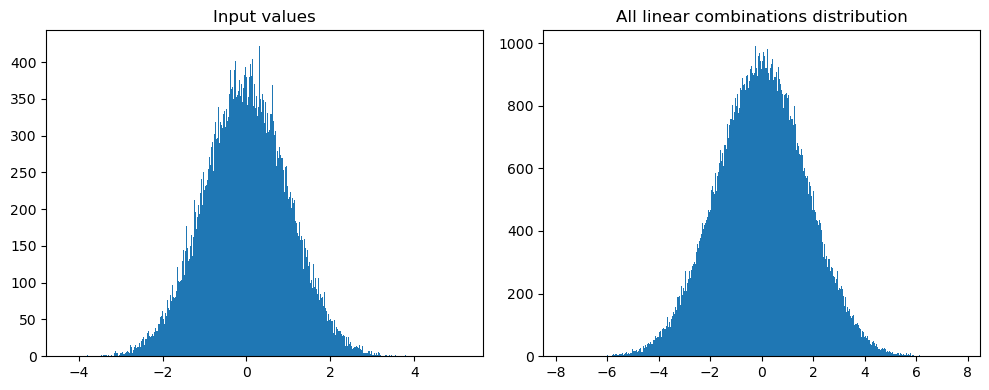

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].hist(lincombs_values, bins=1000)
ax[1].set_title("All linear combinations distribution")
ax[0].hist(enrolled, bins=1000)
ax[0].set_title("Input values")

plt.tight_layout()
plt.show()

Linear combination results seem to be normal distributed. 
Let's caluclate the quanzizing bounds based on that distribution and try to optimize our points away from there

In [58]:
# Define number of bits to quantize
m = 2

# Quantizer bounds in the Tilde Domain
bounds = list(np.linspace(0, 1, 2**m+1))

# Bounds real can now be used as constatints for the linear combination to opitmize the input values
bounds_real= list(map(lambda x: sct.norm.ppf(x, loc=0, scale=lincombs_values.std()), bounds))


We can first implement the conventional stategy of opimizing the weights 

To do this, we will assume that a weight combination is optimal if the distance to the nearest quantization bound is maximized. 

In [ ]:
# For every entry in lincomb_sets, iterate over every possible linear combination and calulate the distance to the bounds. 
# Find the nearest bound and save the bound for that linear combination. 
# Then, select the linear combinations with the highest distance, the resulting
# weights, is the thing that we want to have  

for set in lincomb_sets:
    # Linear combination with the minimal distance fo a bound
    for lincomb in set: 
        